# PyEI Overview

PyEI is a Python package for performing ecological inference. It is meant to gather together in one place several approaches to ecological inference, to provide helpful features for plotting and reporting and results, and to integrate with other tools that facilitate model comparison and model checking.

Start here if you have some familiarity with ecological inference (EI), and want an overview of how to use PyEI and its main features.

If you are new to ecological inference, the Introduction notebook might be a better place to start.

For a more detailed gallery of plotting functionality, see the Plotting notebook.

For information about model checking and model comparison, see the Model Checking notebook.

# Contents:

- Loading data to use
- Fitting a model for EI
- Plotting overview
- Reporting results overview
- Accessing samples
- Currently available models
- Convergence issues and warnings

In [1]:
import numpy as np
import pymc as pm

from pyei.data import Datasets
from pyei.two_by_two import TwoByTwoEI
from pyei.goodmans_er import GoodmansER
from pyei.goodmans_er import GoodmansERBayes
from pyei.r_by_c import RowByColumnEI

/Users/karin/miniconda/envs/pyei_4/lib/python3.10/site-packages/aesara/link/jax/dispatch.py:87: UserWarning: JAX omnistaging couldn't be disabled: Disabling of omnistaging is no longer supported in JAX version 0.2.12 and higher: see https://github.com/google/jax/blob/main/design_notes/omnistaging.md.
  warnings.warn(f"JAX omnistaging couldn't be disabled: {e}")
/Users/karin/miniconda/envs/pyei_4/lib/python3.10/site-packages/pymc/sampling_jax.py:36: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


# Loading data to use

`PyEI` provides access to several example datasets for getting started. We can load the Santa Clara dataset, with its 42 precincts, and convert it to a DataFrame with `data = Datasets.Santa_Clara.to_dataframe().` We'll be passing various columns of this DataFrame to PyEI.

Whether you are using an example data set or your own data, here is what you will need to pass to the various EI methods:

   - A vector of length `num_precincts` giving the population of each precincts. Depending on your purposes and data, the appropriate measure of population may be CVAP, VAP, etc. Below we name this `precinct_pops`.
   
   - For 2 x 2 EI:
      * A vector of length `num_precints` whose entries are each numbers between zero and 1 that give the fraction of the population of each precinct who belong to the demographic group of interest. Below we name this `group_fraction`.
      * A vector of length `num_precincts` whose entries are each numbers beteween zero and 1 that give the fraction of voters in each precinct voting for the candidate of interest (or, if we are estimating turnout, who voted at all). Below, we name this `votes_fraction`.
      * Optionally: name of the candidate of interest, name of the demographic group of interest, and/or names of precincts (for use in PyEI's plotting and reporting).
       
   - For $r$ x $c$ EI:
      * An array of shape $r$ x `num_precints` whose entries are each numbers between zero and 1 that give the fraction of the population of each precinct who belong to each of the $r$ demographic groups of interest (these fractions should sum to 1 for each precinct). Each row should sum to 1. Below we name this `group_fractions`.
      * An array of shape $c$ x `num_precincts` whose entries are each numbers beteween zero and 1 that give the fraction of voters in each precinct voting for each of $c$ candidates of interest (or, if we are considering turnout, who voted or did not vote). Each row should sum to 1. Below, we name this `votes_fractions`.
      * Optionally: A vector of length $c$ giving the names of the candidates and a vector of length $r$ giving the name of the demographic groups and/or names of precincts (will be used in PyEI's plotting and reporting).

In [2]:
# Example 2x2 data
santa_clara_data = Datasets.Santa_Clara.to_dataframe()

group_fraction_2by2 = np.array(santa_clara_data["pct_e_asian_vote"])
votes_fraction_2by2 = np.array(santa_clara_data["pct_for_hardy2"])
precinct_pops = np.array(santa_clara_data["total2"])

demographic_group_name_2by2 = "e_asian"
candidate_name_2by2 = "Hardy"
precinct_names = santa_clara_data['precinct']

santa_clara_data.head()

,precinct,total_turnout,total2,pct_for_hardy2,pct_for_kolstad2,pct_for_nadeem2,total5,pct_for_caserta5,pct_not_caserta5,pct_for_lacoursiere5,...,pct_for_park5,pct_not_park5,pct_asian_vote,pct_asian_pop,pct_ind_vote,pct_ind_pop,pct_e_asian_vote,pct_e_asian_pop,pct_non_asian_vote,pct_non_asian_pop
0,4201,712,658,0.246201,0.431611,0.322188,642,0.447041,0.552960,0.305296,...,0.247664,0.752336,0.054775,0.117369,0.008427,0.028632,0.046348,0.088736,0.945225,0.882631
1,4208,400,380,0.328947,0.431579,0.239474,379,0.456464,0.543536,0.192612,...,0.350923,0.649076,0.197500,0.214389,0.060000,0.075990,0.137500,0.138399,0.802500,0.785611
2,4211,609,549,0.251366,0.384335,0.364299,542,0.492620,0.507380,0.250922,...,0.256458,0.743542,0.123153,0.202214,0.042693,0.046066,0.080460,0.156147,0.876847,0.797786
3,4215,623,573,0.258290,0.371728,0.369982,558,0.431900,0.568100,0.344086,...,0.224014,0.775986,0.109149,0.162014,0.032103,0.040379,0.077047,0.121635,0.890851,0.837986
4,4217,399,359,0.281337,0.406685,0.311978,355,0.425352,0.574648,0.326761,...,0.247887,0.752113,0.142857,0.254478,0.027569,0.063619,0.115288,0.190859,0.857143,0.745522


In [3]:
# Example rxc data (here r=c=3)
santa_clara_data = Datasets.Santa_Clara.to_dataframe() # This line same as 2x2 example

group_fractions_rbyc = np.array(santa_clara_data[['pct_ind_vote', 'pct_e_asian_vote', 'pct_non_asian_vote']]).T
votes_fractions_rbyc = np.array(santa_clara_data[['pct_for_hardy2', 'pct_for_kolstad2', 'pct_for_nadeem2']]).T
precinct_names = santa_clara_data['precinct'] # This line same as 2x2 example

candidate_names_rbyc = ["Hardy", "Kolstad", "Nadeem"]
demographic_group_names_rbyc = ["ind", "e_asian", "non_asian"]
precinct_pops = np.array(santa_clara_data['total2']) # This line same as 2x2 example

# Fitting a model for EI

We fit most models by first creating a `TwoByTwoEI`, `RowByColumnEI` or `GoodmanERBayes` object, which is initialized with a (required) model name that is chosen among the supported models and (if desired) the applicable model parameters, then calling its `fit` method, with the relevant data as arguments. We can also, optionally, pass arguments to specify sampling choices like the number of MCMC draws.

We also can pass to the fit() function of `TwoByTwoEI`, `RowByColumnEI`, or `GoodmanERBayes` additional keyword arguments for the sampler, such as:

- draws - the number of samples to draw
- chains - the number of chains
- tune - number of iteration to tune
- cores - number of chains to run in parallel

(see https://docs.pymc.io/api/inference.html sampling.sample for more)
E.g.:

We fit a Goodman's ecological regression model by creating a `GoodmanER` or `GoodmanERBayes` object and then calling its fit method.

In [4]:
# Fitting a first 2 x 2 model

# Create a TwobyTwoEI object
ei_2by2 = TwoByTwoEI(model_name="king99_pareto_modification", pareto_scale=15, pareto_shape=2)

# Fit the model
ei_2by2.fit(group_fraction_2by2, 
       votes_fraction_2by2, 
       precinct_pops, 
       demographic_group_name=demographic_group_name_2by2, 
       candidate_name=candidate_name_2by2, 
       precinct_names=precinct_names, 
       draws=1200, # optional
       tune=3000, # optional
       target_accept=.99# optional
)

# Generate a simple report to summarize the results
print(ei_2by2.summary())

/Users/karin/miniconda/envs/pyei_4/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Compiling...


/Users/karin/miniconda/envs/pyei_4/lib/python3.10/site-packages/pymc/aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(


Compilation time =  0:00:11.055973
Sampling...


Compiling.. :   0%|                                                       | 0/4200 [00:00<?, ?it/s]

  0%|                                                                     | 0/4200 [00:00<?, ?it/s]

Compiling.. :   0%|                                                       | 0/4200 [00:00<?, ?it/s]


  0%|                                                                     | 0/4200 [00:00<?, ?it/s]


Running chain 1:   0%|                                                    | 0/4200 [00:25<?, ?it/s]


Running chain 0:   0%|                                                    | 0/4200 [00:25<?, ?it/s]

Running chain 1:   5%|██                                       | 210/4200 [00:25<00:08, 476.39it/s]

Running chain 2:   5%|██                                       | 210/4200 [00:25<00:11, 347.76it/s]


Running chain 1:  10%|████                                     | 420/4200 [00:26<00:09, 415.51it/s]

Running chain 2:  10%|████                                     | 420/4200 [00:26<00:08,

Sampling time =  0:00:37.395143
Transforming variables...
Transformation time =  0:00:00.659089
Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        e_asian for Hardy is
        0.805
        The posterior mean for the district-level voting preference of
        non-e_asian for Hardy is
        0.245
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        e_asian for Hardy is
        [0.61286294 0.95418974]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-e_asian for Hardy is
        [0.21893767 0.27786349]
        


In [5]:
# Fitting a first r x c model

# Create a RowByColumnEI object
ei_rbyc = RowByColumnEI(model_name='multinomial-dirichlet-modified', pareto_shape=100, pareto_scale=100)

# Fit the model
ei_rbyc.fit(group_fractions_rbyc, 
       votes_fractions_rbyc, 
       precinct_pops, 
       demographic_group_names=demographic_group_names_rbyc, 
       candidate_names=candidate_names_rbyc, 
       #precinct_names=precinct_names, 
)

# Generate a simple report to summarize the results
print(ei_rbyc.summary())

Running ['ind', 'e_asian', 'non_asian'] x ['Hardy', 'Kolstad', 'Nadeem'] EI
r = 3 rows (demographic groups)
c = 3 columns (candidates or voting outcomes)
number of precincts = 42
Compiling...


/Users/karin/miniconda/envs/pyei_4/lib/python3.10/site-packages/pymc/aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(


Compilation time =  0:00:13.353159
Sampling...


Compiling.. :   0%|                                                       | 0/2500 [00:00<?, ?it/s]

  0%|                                                                     | 0/2500 [00:00<?, ?it/s]

Compiling.. :   0%|                                                       | 0/2500 [00:00<?, ?it/s]


  0%|                                                                     | 0/2500 [00:00<?, ?it/s]


Compiling.. :   0%|                                                       | 0/2500 [00:00<?, ?it/s]

Running chain 0:   0%|                                                    | 0/2500 [00:13<?, ?it/s]


Running chain 3:   0%|                                                    | 0/2500 [00:13<?, ?it/s]


Running chain 1:   5%|██                                        | 125/2500 [00:16<00:58, 40.32it/s]

Running chain 0:   5%|██                                        | 125/2500 [00:17<01:04, 36.87it/s]


Running chain 0:  10%|████▏                                     | 250/2500 [00:18<00:4

Sampling time =  0:02:27.934393
Transforming variables...
Transformation time =  0:00:01.688659

            Computed from the raw b_ samples by multiplying by group populations and then
            getting the proportion of the total pop
            (total pop=summed across all districts):
            The posterior mean for the district-level voting preference of
                ind for Hardy is
                0.172
                95% equal-tailed credible interval:  [0.01364021 0.48026359]
                The posterior mean for the district-level voting preference of
                ind for Kolstad is
                0.111
                95% equal-tailed credible interval:  [0.00296163 0.37983873]
                The posterior mean for the district-level voting preference of
                ind for Nadeem is
                0.717
                95% equal-tailed credible interval:  [0.40302554 0.94131064]
                The posterior mean for the district-level voting preference 

In [6]:
# Fitting Goodman's ER - precincts not weighted by population

# Create a GoodmansER object
goodmans_er = GoodmansER() 

# Fit the model
goodmans_er.fit(
    group_fraction_2by2, 
    votes_fraction_2by2,
    demographic_group_name=demographic_group_name_2by2, 
    candidate_name=candidate_name_2by2
)

# Generate a simple report to summarize the results
print(goodmans_er.summary())

# Fitting Goodman's ER - precincts weighted by population
goodmans_er = GoodmansER(is_weighted_regression="True")

goodmans_er.fit(group_fraction_2by2, 
    votes_fraction_2by2,
    precinct_pops, # Must include populations if weighting by population
    demographic_group_name=demographic_group_name_2by2, 
    candidate_name=candidate_name_2by2
)

print(goodmans_er.summary())

Goodmans ER
        Est. fraction of e_asian
        voters who voted for Hardy is
        0.862
        Est. fraction of non- e_asian
        voters who voted for Hardy is
        0.239
        
Goodmans ER, weighted by population
        Est. fraction of e_asian
        voters who voted for Hardy is
        0.865
        Est. fraction of non- e_asian
        voters who voted for Hardy is
        0.236
        


In [7]:
# Fitting Goodman's ER - Bayesian variant with priors over the intercepts with x=0 and x=1

bayes_goodman_ei = GoodmansERBayes("goodman_er_bayes", weighted_by_pop=True, sigma=1)

bayes_goodman_ei.fit(
    group_fraction_2by2, 
    votes_fraction_2by2,
    precinct_pops,
    demographic_group_name=demographic_group_name_2by2, 
    candidate_name=candidate_name_2by2
)


Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
/Users/karin/miniconda/envs/pyei_4/lib/python3.10/site-packages/pymc/aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b_1, b_2, eps]
INFO:pymc:NUTS: [b_1, b_2, eps]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 26 seconds.
INFO:pymc:Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 26 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
INFO:pymc:We recommend running at least 4 chains for robust computation of convergence diagnostics


# Plotting overview

PyEI has a number of plots available. Here is a list of available plots.

Plotting methods for any fitted EI model where inference involves sampling -- i.e. all approaches except the (non-Bayesian) Goodman's ER

- Summary plots for distributions of polity-wide voter preferences
    - `plot`
    - `plot_kde` (2 by 2)
    - `plot_kdes` ($r$ by $c$)
    - `plot_boxplot` (2 by 2)
    - `plot_boxplots` ($r$ by $c$)
    - `plot_intervals` (2 by 2)

- Plots of polarization
    - `plot_polarization_kde` (2 by 2)
    - `plot_polarization_kdes` ($r$ by $c$)

For all approaches except Goodman's ER and the Bayesian Goodman's ER (which do not generate samples for each precinct)

- Plots of **precinct-level** voter preferences
    - `precinct_level_plot`
    - `plot_intervals_by_precinct`
        

`GoodmansER` objects also have a plot method
- `plot`

Additional plotting utilities: for tomography plotting and comparing precinct-level posterior means:

- `plot_utils.tomography_plot`
- `plot_precinct_scatterplot`

Here we only display a few of these plots as examples. A more detailed look at the plotting and reporting functionality, see the Plotting and Reporting notebook.

(<AxesSubplot:xlabel='Support for Hardy'>,
 <AxesSubplot:title={'center':'EI Summary'}>)

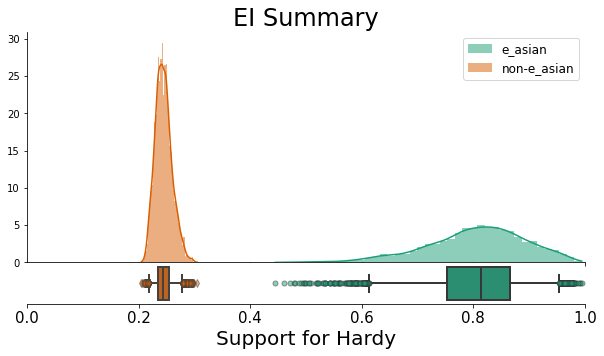

In [8]:
ei_2by2.plot()

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='Fraction in group e_asian', ylabel='Fraction voting for Hardy'>)

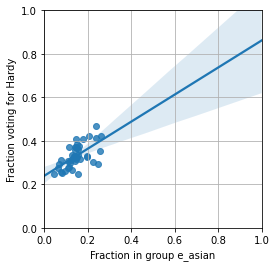

In [9]:
goodmans_er.plot()

<AxesSubplot:title={'center':'Support for Nadeem'}>

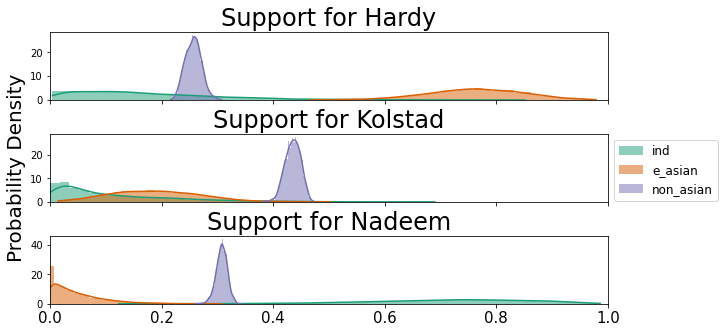

In [10]:
ei_rbyc.plot_kdes(plot_by="candidate") # or, plot_by="group"

<AxesSubplot:title={'center':'Polarization KDE for Hardy'}, xlabel='(e_asian - non-e_asian) support for Hardy', ylabel='Density'>

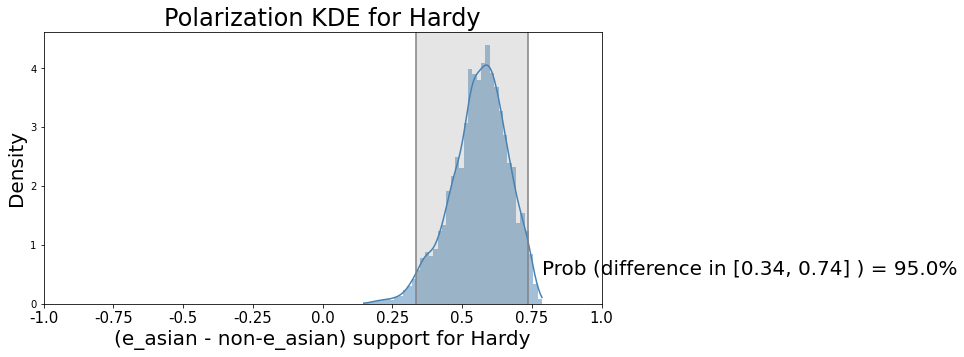

In [11]:
ei_2by2.plot_polarization_kde(percentile=95, show_threshold=True) #set show_threshold to false to just view the kde

<AxesSubplot:title={'center':'Precinct level estimates of voting preferences'}, xlabel='Percent vote for Hardy', ylabel='Precinct'>

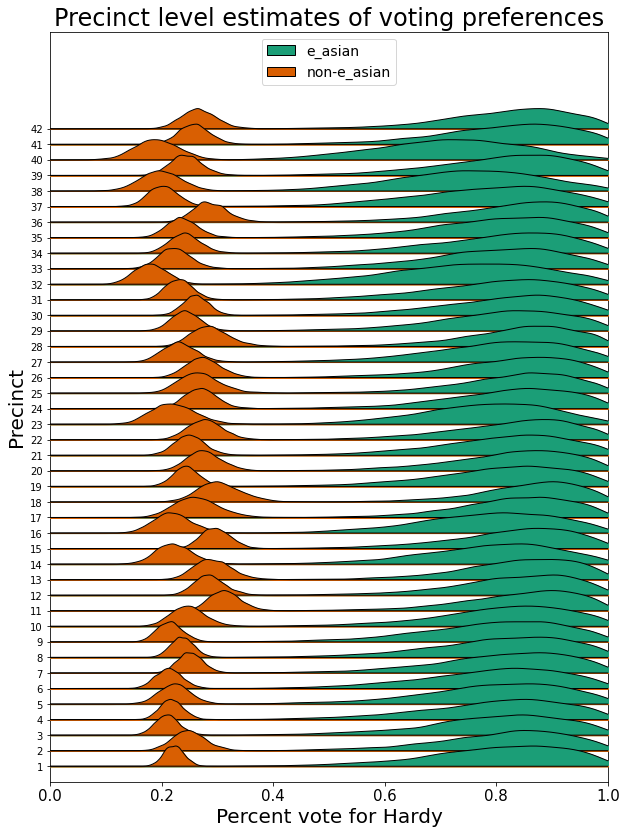

In [12]:
ei_2by2.precinct_level_plot()

# Reporting results overview

See below for examples of how to access/report:
- Polity-wide posterior means and credible intervals of voter preferences
- Precinct-level posterior means and credible intervals of voter preferences
- Information about polarization and candidate of choice

**Polity-wide posterior means and credible intervals of voter preferences:**

In [13]:
# EI objects have a summary method that gives a report
print(ei_2by2.summary()) 

# Can also use for r x c
#print(ei_rbyc.summary())

# Can also use for BayesGoodmansER
#print(bayes_goodman_ei.summary())

# Note: Goodman's ER also has a summary function, although it just gives point esimates
#print(goodmans_er.summary())


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        e_asian for Hardy is
        0.805
        The posterior mean for the district-level voting preference of
        non-e_asian for Hardy is
        0.245
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        e_asian for Hardy is
        [0.61286294 0.95418974]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-e_asian for Hardy is
        [0.21893767 0.27786349]
        


In [14]:
posterior_mean_voting_prefs = ei_2by2.posterior_mean_voting_prefs
print(demographic_group_name_2by2, " support for ", candidate_name_2by2, posterior_mean_voting_prefs[0])
print("non-",demographic_group_name_2by2, " support for ", candidate_name_2by2, posterior_mean_voting_prefs[1])

e_asian  support for  Hardy 0.8052959234705681
non- e_asian  support for  Hardy 0.2448616715568224


In [15]:
credible_interval_95_mean_voting_prefs = ei_2by2.credible_interval_95_mean_voting_prefs
print(demographic_group_name_2by2, " support for ", candidate_name_2by2, credible_interval_95_mean_voting_prefs[0])
print("non-", demographic_group_name_2by2, " support for ", candidate_name_2by2, credible_interval_95_mean_voting_prefs[1])

e_asian  support for  Hardy [0.61286294 0.95418974]
non- e_asian  support for  Hardy [0.21893767 0.27786349]


In [16]:
# Means and intervals for BayesGoodmanER estimates
x_vals, means, lower_bounds, upper_bounds = bayes_goodman_ei.compute_credible_int_for_line()

**Precinct-level posterior means and credible intervals**:

In [17]:
precinct_posterior_means, precinct_credible_intervals = ei_2by2.precinct_level_estimates()
#precinct_posterior_means has shape num_precincts x 2 (groups) x 2 (candidates)
print(precinct_posterior_means[5][0][0]) # Estimated (posterior mean) support for the candidate from the group in precinct 5
#precinct_credible_intervals has shape num_precincts x 2 (groups) x 2 (candidates) x 2 (endpoints))
print(precinct_credible_intervals[5][0][0]) # 95% credible interval of support for the candidate from the group in precint 5

0.7919070336951213
[0.51023386 0.98179042]


**Polarization and candidates of choice**

In [18]:
print(ei_2by2.polarization_report(percentile=95, reference_group=0, verbose=True))

There is a 95% probability that the difference between the groups' preferences for Hardy (e_asian - non-e_asian) is between [0.34, 0.74].
(0.33561848517250137, 0.7354038311499368)


In [19]:
print(ei_2by2.polarization_report(threshold=0.25, reference_group=0, verbose=True))

There is a 99.5% probability that the difference between the groups' preferences for Hardy (e_asian -  non-e_asian) is more than 0.25.
99.47916666666667


In [20]:
# set verbose=False to just show numerical value
ei_2by2.polarization_report(threshold=0.25, reference_group=0, verbose=False) 

99.47916666666667

In [21]:
# For the r by c case, specify the groups you wish to compare and the candidate
print(ei_rbyc.polarization_report(percentile=90, groups=['ind', 'e_asian'], candidate='Kolstad', verbose=True))

There is a 90% probability that the difference between the groups' preferences for Kolstad (ind - e_asian) is between [-0.28, 0.20].
(-0.2847146255164417, 0.19665881443078054)


In [22]:
ei_rbyc.candidate_of_choice_report(verbose=True) #pass a verbose=False argument to just output the dictionary

ind
     - In 2.825 percent of samples, the district-level vote preference of 
       ind for Hardy was higher than for any other candidate.
     - In 0.95 percent of samples, the district-level vote preference of 
       ind for Kolstad was higher than for any other candidate.
     - In 96.225 percent of samples, the district-level vote preference of 
       ind for Nadeem was higher than for any other candidate.
e_asian
     - In 99.975 percent of samples, the district-level vote preference of 
       e_asian for Hardy was higher than for any other candidate.
     - In 0.025 percent of samples, the district-level vote preference of 
       e_asian for Kolstad was higher than for any other candidate.
     - In 0.0 percent of samples, the district-level vote preference of 
       e_asian for Nadeem was higher than for any other candidate.
non_asian
     - In 0.0 percent of samples, the district-level vote preference of 
       non_asian for Hardy was higher than for any other candidate

{('ind', 'Hardy'): 0.02825,
 ('ind', 'Kolstad'): 0.0095,
 ('ind', 'Nadeem'): 0.96225,
 ('e_asian', 'Hardy'): 0.99975,
 ('e_asian', 'Kolstad'): 0.00025,
 ('e_asian', 'Nadeem'): 0.0,
 ('non_asian', 'Hardy'): 0.0,
 ('non_asian', 'Kolstad'): 1.0,
 ('non_asian', 'Nadeem'): 0.0}

In [23]:
# For each pair of groups, this function reports the fraction samples for which
# the `preferred candidate` of one group (as measured by: who is the candidate supported
# by the plurality within that group according to the sampled district-level support value)
# is different from the `preferred candidate` of the others group
ei_rbyc.candidate_of_choice_polarization_report() #pass a verbose=False argument to just output the relevant numerica values

In 97.175 percent of samples, the district-level candidates of choice for e_asian and ind voters differ.
In 99.05 percent of samples, the district-level candidates of choice for non_asian and ind voters differ.
In 99.975 percent of samples, the district-level candidates of choice for non_asian and e_asian voters differ.


{('e_asian', 'ind'): 0.97175,
 ('ind', 'e_asian'): 0.97175,
 ('non_asian', 'ind'): 0.9905,
 ('ind', 'non_asian'): 0.9905,
 ('non_asian', 'e_asian'): 0.99975,
 ('e_asian', 'non_asian'): 0.99975}

# Accessing samples

Most of the models that PyEI supports (although not Goodman's regression) are Bayesian models, and inference proceeds by using MCMC methods to sample from the posterior distributions of interest. Samples are accessible so that you can work with them directly if desired.

We can use the `sampled_voting_prefs` property of a fitted EI object to access the samples of district-level voter prefernences of each group for each candidate, which are calculated by weighting each set of precinct-level samples by the population and summing.

We can also access samples from the posterior distribution by accessing them by name from the fitted ei object's `sim_trace` property.

In [24]:
# Using `sampled_voting_prefs`

sampled_voting_prefs = ei_2by2.sampled_voting_prefs # ei.sampled_voting_prefs is samples of district-level voter preference: list of length 2
sampled_voting_prefs[0] #samples of district-wide support of specified group for specified candidate
sampled_voting_prefs[1] #samples of district-wide support of (complement of specified group) for specified candidate
sampled_voting_prefs[0].mean() #posterior mean
sampled_voting_prefs[1].mean() #posterior mean

0.2448616715568224

In [30]:
# By name of parameters, using the fitted ei object's `sim_trace` property.

# Shape is: num_samples x (dimensionality of parameter)
ei_2by2.sim_trace['posterior']['b_1'] # shape is chains x draws x precincts

# Shape is: num_samples x (dimensionality of parameter)
ei_rbyc.sim_trace['posterior']['kappa']

# Note - to collapose chains and draws into one dimension you can do e.g.
# sim_trace["posterior"]["b_1"].stack(all_draws=["chain", "draw"]).values.T 
# which gives a (chains*num_draws) x num_precincts array

<xarray.DataArray 'kappa' (chain: 4, draw: 1000, kappa_dim_0: 3)>
array([[[102.1162844 , 100.89372734, 100.04201911],
        [100.38211604, 100.43877389, 101.03309791],
        [101.02491874, 102.15062353, 101.32758877],
        ...,
        [101.78446553, 102.51214794, 101.4407413 ],
        [100.29539295, 100.24684551, 100.77645406],
        [105.21277181, 102.18022367, 100.27492476]],

       [[100.39587757, 100.28146039, 101.80568947],
        [101.19988396, 100.69355619, 100.49452521],
        [102.48647963, 101.0682576 , 100.97228004],
        ...,
        [101.65366782, 100.60856329, 100.16574469],
        [100.56357968, 100.96434362, 101.27794863],
        [100.32440155, 101.6277532 , 102.08866821]],

       [[100.12651401, 100.51639394, 100.19519136],
        [100.29135743, 101.21565272, 100.78766617],
        [100.74940105, 101.34254186, 100.54010621],
        ...,
        [100.14741068, 101.72719647, 100.21256441],
        [102.52300389, 100.0593272 , 103.21750585],
        [102.75531319, 100.05501632, 100.23449337]],

       [[101.26054117, 101.53644449, 100.44879566],
        [100.6174847 , 101.84667092, 100.96057342],
        [100.97890136, 100.3049145 , 100.90269008],
        ...,
        [101.63073079, 102.16710358, 100.88671061],
        [100.70614526, 100.3949798 , 101.13301241],
        [100.44281172, 102.05244181, 100.92092081]]])
Coordinates:
  * chain        (chain) int64 0 1 2 3
  * draw         (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * kappa_dim_0  (kappa_dim_0) int64 0 1 2

# Currently supported models - quick reference

The names of currently supported models are as follows:

- TwoByTwoEI
    * `king99`
    * `king99_pareto_modification`
    * `wakefield_beta` 
    * `wakefield_normal`  (caution: sampling difficulties)
    * `truncated_normal`
    
- RowByColumnEI
    * `multinomial-dirichlet`
    * `multinomial-dirichlet-modified`
    
- GoodmansER
    * `is_weighted_regression=False` (not weighted by precinct populations)
    * `is_weighted_regression=True` (weighted by precinct populations)
  
- GoodmansERBayes

Using pymc3's `model_to_graphviz` function is a nice way to visualize the Bayesian models. For example:

In [36]:
model = ei_2by2.sim_model
m = pm.model_to_graphviz(model)
m.show()

AttributeError: 'Digraph' object has no attribute 'show'

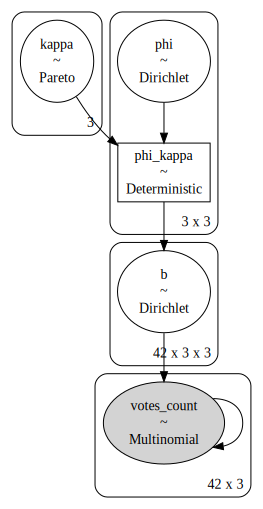

In [35]:
model = ei_rbyc.sim_model
pm.model_to_graphviz(model)

# Convergence issues and warnings

There may be [convergence](https://mc-stan.org/docs/2_27/reference-manual/convergence.html) issues when fitting models to data. The presence of [divergences](https://mc-stan.org/docs/2_27/reference-manual/divergent-transitions.html) (especially a large number of divergences), a high value of [$\hat{R}$](https://mc-stan.org/docs/2_27/reference-manual/notation-for-samples-chains-and-draws.html) (a convergence diagnostic calculated by comparing multiple chains - more samples will generally lower it, and looking for a value below 1.1 is a good rule of thumb), and a low [effective sample size](https://mc-stan.org/docs/2_27/reference-manual/effective-sample-size-section.html) are three signs that there were computational difficulties during sampling that may have made the results inaccurate. 

`PyEI` relies on `PyMC3` for sampling, and thus benefits from the diagnostic checks that `PyMC3` automatically performs, and their associated warnings. (For some examples of how to compute and access convergence diagnostics with `PyEI` (using the [`ArviZ`](https://arviz-devs.github.io/arviz/) library), see `examples/model_eval_and_comparison_demo.ipynb`.) `PyEI` is thus intentionally vocal about computational difficulties that may be encountered. The warnings issued should be taken seriously, as they indicate that the samples generated may not be representative of the posterior distribution, in which case results derived from these samples should not be trusted.

If convergence issues are encountered, there are several steps the user can take that may help mitigate; we mention several here and encourage the user to consult helpful resources in e.g. within the [`PyMC3`](https://pymc3.readthedocs.io/en/latest/notebooks/Diagnosing_biased_Inference_with_Divergences.html) and [`Stan`](https://mc-stan.org/users/documentation/case-studies/divergences_and_bias.html) documentation. 

Increasing the optional `target_accept` argument to the fit method might help ("might" because the default value of 0.99 is already quite high, and the sorts of geometric problems that frustrate the sampler require an exponentially different scale). Increasing the number of tuning steps (by setting the `tune` argument of the fit method) is sometimes helpful by giving `PyMC3` more time to estimate a step size and covariance matrix, and increasing the total number of draws (with the `draws` argument of the fit method) will allow for a larger effective sample size (at the cost of more computation time).

Another, more involved approach to take would be [reparametrizing](https://mc-stan.org/docs/2_27/stan-users-guide/reparameterization-section.html) the model, which changes the posterior geometry in ways that (hopefully) ease computational difficulties. For example, the `king99_pareto_modification` model implemented in `PyEI` is a reparametrization of the `king99` model that is in the literature. On the Santa Clara example dataset, the modified (reparameterized) model encounters fewer computational issues (see example below). However, `king99_pareto_modification` does not so far seem to outperform `king99` in all settings, so the user may wish to try both.

Computational difficulties can be a symptom of poor choice of model for the data at hand, and so it is possible that computational issues indicate a fundamental unsuitability of the ecological inference model to the data at hand. It is the authors' hope that additional ecological inference approaches may be developed that avoid some of the computational difficulties that seem to occur in sampling from existing models.

In [ ]:
# Witting this particular EI model to the Santa Clara example data 
# results in computational difficulties 
ei_2by2orig = TwoByTwoEI(model_name="king99", lmbda=0.5)

# Fit the model
ei_2by2orig.fit(group_fraction_2by2, 
       votes_fraction_2by2, 
       precinct_pops, 
       demographic_group_name=demographic_group_name_2by2, 
       candidate_name=candidate_name_2by2, 
       precinct_names=precinct_names, 
       draws=1200, # optional
       tune=3000, # optional
       target_accept=.99# optional
)

# Generate a simple report to summarize the results
print(ei_2by2orig.summary())

In [ ]:
# Using this reparametrized version of the model helps mitigate the problems,
# although some difficulties persist
# Create a TwobyTwoEI object
ei_2by2 = TwoByTwoEI(model_name="king99_pareto_modification", pareto_scale=15, pareto_shape=2)

# Fit the model
ei_2by2.fit(group_fraction_2by2, 
       votes_fraction_2by2, 
       precinct_pops, 
       demographic_group_name=demographic_group_name_2by2, 
       candidate_name=candidate_name_2by2, 
       precinct_names=precinct_names, 
       draws=1200, # optional
       tune=3000, # optional
       target_accept=.99 # optional
)

# Generate a simple report to summarize the results
print(ei_2by2.summary())